# **Download Dataset**

In [1]:
! gdown --id 1wBaZeI95C3-3rr0qaUvWZdooUKi28VFe
! unzip -q /content/Xray_dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wBaZeI95C3-3rr0qaUvWZdooUKi28VFe
To: /content/Xray_dataset.zip
100% 59.8M/59.8M [00:02<00:00, 21.4MB/s]


# **Install Requirements**

In [ ]:
! pip install torchmetrics
! pip install torch-fidelity
! pip install torchmetrics[image]

# **Define Generative Model**

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import datetime
import os
import os.path
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
# Number of training epochs
num_epochs = 200
LOAD_MODEL = False


TRAIN_ALL = False
#All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
criterion = nn.BCELoss()

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.5),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [11]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    fname = os.path.join('.', 'augGAN/model', name)
    states = {
            'state_dict_generator': generator.state_dict(),
            'state_dict_discriminator': discriminator.state_dict(),
            'gen_optimizer': gen_optimizer.state_dict(),
            'dis_optimizer': dis_optimizer.state_dict(),
            'metrics': metrics,
            'train_epoch': num_epochs,
            'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    }
    torch.save(states, fname)
    path='augGAN/plots/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)



In [13]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance


img_list = []
G_losses = []
D_losses = []
fid = FrechetInceptionDistance(feature=64, normalize=True).cuda()
inception = InceptionScore(normalize=True).cuda()


def train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader, num_epochs, metrics):
        iters = 0
        print("GAN training started :D...")

        for epoch in range(num_epochs):
            print("Epoch %d" %(epoch+1))
            # For each batch in the dataloader
            for i, data in enumerate(tqdm(train_loader, 0)):
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ## Train with all-real batch
                discriminator.zero_grad()
                # Format batch
                b_real = data[0].to(device)
                b_size = b_real.size(0)
                label = torch.full((b_size,), real_label, device=device)
                # Forward pass real batch through D
                output = discriminator(b_real).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()
                metrics['train.D_x'].append(D_x)

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                # Generate fake image batch with G
                fake = generator(noise)

                # InceptionScore
                fid.update(torch.tensor(b_real, dtype=torch.float32).repeat(1, 3, 1, 1), real=True)
                fid.update(torch.tensor(fake, dtype=torch.float32).repeat(1, 3, 1, 1), real=False)
                metrics['fid'].append(fid.compute())

                # FrechetInceptionDistance
                inception.update(torch.tensor(fake, dtype=torch.float32).repeat(1, 3, 1, 1))
                mean_is, std_is = inception.compute()
                metrics['is'].append(mean_is)

                label.fill_(fake_label)
                # Classify all fake batch with D
                output = discriminator(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                metrics['train.D_G_z1'].append(D_G_z1)
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                dis_optimizer.step()

                generator.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = discriminator(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                metrics['train.D_G_z2'].append(D_G_z2)
                # Update G
                gen_optimizer.step()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())
                metrics['train.G_losses'].append(errG.item())
                metrics['train.D_losses'].append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
                    with torch.no_grad():
                        fake = generator(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), "FID:", fid.compute().item(), "InceptionScore:",mean_is.item())
        save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs)

In [14]:
def get_indices(dataset, class_name, indices):
    j = 0
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
            j += 1
    print("Total Samples of class", class_name,"found are",j)
    return indices

In [18]:
def visualize_generated_imgs(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images'
    try:
      os.makedirs(os.path.join('.', path), exist_ok=True)
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                    (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [19]:
def synthesize_imgs(generator, discriminator, metrics, n_images, folname):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    pathc=f'augGAN/output_images/{n_images}/'
    pathn=f'{folname}'

    try:
      os.makedirs(os.path.join('.', pathc),exist_ok=True)
      os.makedirs(os.path.join(pathc, pathn), exist_ok=True)
    except Exception as error:
      print(error)

    im_batch_size = 50
    #n_images=100
    for i_batch in range(0, n_images, im_batch_size):
        gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
        gen_images = generator(gen_z)
        dis_result = discriminator(gen_images).view(-1)
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join(pathc  + pathn, 
                        f'image_{i_batch+i_image:04d}.png'), normalize= True)

    print('Testing Block.........')
    print('Discriminator_mean: ', dis_result.mean().item())


# **Train The Model**

In [20]:
for func in [
    lambda: os.makedirs(os.path.join('.', 'augGAN'), exist_ok=True),
    lambda: os.makedirs(os.path.join('.', 'augGAN/model'), exist_ok=True),
    lambda: os.makedirs(os.path.join('.', 'augGAN/plots'), exist_ok=True),
    lambda: os.makedirs(os.path.join('.', 'augGAN/output_images'), exist_ok=True)]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)
    continue

METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
    'fid',
    'is',
    
]
metrics = {field: list() for field in METRIC_FIELDS}

if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    #Originally authors used just scaling
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")

data_dir = '/content/Xray_dataset'

trainset0 = datasets.ImageFolder(os.path.join(
          data_dir, "train/"), transform=transform)
trainset500 = datasets.ImageFolder(os.path.join(
          data_dir, "train_classic/500/"), transform=transform)
trainset1000 = datasets.ImageFolder(os.path.join(
          data_dir, "train_classic/1000/"), transform=transform)
trainset2000 = datasets.ImageFolder(os.path.join(
          data_dir, "train_classic/2000/"), transform=transform)
listtrainset_no_aug = [trainset0]
listtrainset_classic = [trainset500,trainset1000]
listtrainset = listtrainset_no_aug + listtrainset_classic
train_set = torch.utils.data.ConcatDataset(listtrainset)


generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

if LOAD_MODEL:
    if torch.cuda.is_available():
      checkpoint = torch.load(PATH)
    else:
      checkpoint = torch.load(PATH, map_location=lambda storage, loc: storage)
              
    generator.load_state_dict(checkpoint['state_dict_generator'])
    discriminator.load_state_dict(checkpoint['state_dict_discriminator'])
    gen_optimizer.load_state_dict(checkpoint['gen_optimizer'])
    dis_optimizer.load_state_dict(checkpoint['dis_optimizer'])
    metrics=checkpoint['metrics']
    num_epochs=checkpoint['train_epoch']
    date=checkpoint['date']
    generator.train(mode=False)
    discriminator.train(mode=False)
    print('GAN loaded for epochs: ', num_epochs)
    print(generator)
    print(discriminator)
    print(gen_optimizer)
    print(dis_optimizer)
    print(date)
else:
    if TRAIN_ALL:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                  shuffle=True)
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, train_loader,
                  num_epochs, metrics)
        test2(generator, discriminator, num_epochs, metrics, train_loader)
    else:
 
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                  shuffle=True)
        mask =[x[1]==0 for x in train_loader.dataset] #here is 0 for covid; 1 for normal; 2 for pneumonia_bacteria; 3 for pneumonia_virus for x-ray dataset
        idx= np.arange(len(train_loader.dataset))[mask]

        print("Total samples now are ",len(idx))
        selected_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                      sampler = SubsetRandomSampler(idx))
        train_gan(generator, discriminator, gen_optimizer, dis_optimizer, selected_loader,
                  num_epochs, metrics)
     

Total samples now are  1060
GAN training started :D...
Epoch 1


  0%|          | 0/34 [00:00<?, ?it/s]<ipython-input-13-1ebd68649289>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(b_real, dtype=torch.float32).repeat(1, 3, 1, 1), real=True)
<ipython-input-13-1ebd68649289>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid.update(torch.tensor(fake, dtype=torch.float32).repeat(1, 3, 1, 1), real=False)
<ipython-input-13-1ebd68649289>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inception.update(torch.tensor(fake, dtype=torch.float32).repeat(1, 3, 1, 1))
100%|██████████|

[1/200][33/34]	Loss_D: 4.8565	Loss_G: 2.0584	D(x): 0.1921	D(G(z)): 0.7486 / 0.1499 FID: 38.516700744628906 InceptionScore: 1.9731520414352417
Epoch 2


100%|██████████| 34/34 [00:07<00:00,  4.28it/s]


[2/200][33/34]	Loss_D: 2.3246	Loss_G: 1.3825	D(x): 0.4129	D(G(z)): 0.5741 / 0.3728 FID: 34.699947357177734 InceptionScore: 2.118464231491089
Epoch 3


100%|██████████| 34/34 [00:07<00:00,  4.28it/s]


[3/200][33/34]	Loss_D: 2.5154	Loss_G: 0.7185	D(x): 0.1877	D(G(z)): 0.4307 / 0.5714 FID: 31.295034408569336 InceptionScore: 2.243130683898926
Epoch 4


100%|██████████| 34/34 [00:08<00:00,  4.25it/s]


[4/200][33/34]	Loss_D: 1.9953	Loss_G: 1.9292	D(x): 0.4331	D(G(z)): 0.4246 / 0.1698 FID: 29.286792755126953 InceptionScore: 2.29431414604187
Epoch 5


100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


[5/200][33/34]	Loss_D: 2.6836	Loss_G: 3.1840	D(x): 0.3583	D(G(z)): 0.5868 / 0.0937 FID: 27.59095573425293 InceptionScore: 2.345503568649292
Epoch 6


100%|██████████| 34/34 [00:08<00:00,  4.19it/s]


[6/200][33/34]	Loss_D: 2.2210	Loss_G: 0.9370	D(x): 0.3235	D(G(z)): 0.5069 / 0.4348 FID: 26.57406997680664 InceptionScore: 2.356907606124878
Epoch 7


100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


[7/200][33/34]	Loss_D: 2.4067	Loss_G: 0.8796	D(x): 0.2979	D(G(z)): 0.5487 / 0.4197 FID: 24.881912231445312 InceptionScore: 2.407799482345581
Epoch 8


100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


[8/200][33/34]	Loss_D: 1.3092	Loss_G: 1.4477	D(x): 0.5633	D(G(z)): 0.3879 / 0.2500 FID: 22.53005027770996 InceptionScore: 2.4818947315216064
Epoch 9


100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


[9/200][33/34]	Loss_D: 2.2552	Loss_G: 1.7326	D(x): 0.3930	D(G(z)): 0.6166 / 0.2512 FID: 20.680898666381836 InceptionScore: 2.5054562091827393
Epoch 10


100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


[10/200][33/34]	Loss_D: 1.4803	Loss_G: 1.0206	D(x): 0.4462	D(G(z)): 0.3999 / 0.3986 FID: 19.17447280883789 InceptionScore: 2.5303587913513184
Epoch 11


100%|██████████| 34/34 [00:08<00:00,  4.16it/s]


[11/200][33/34]	Loss_D: 1.6925	Loss_G: 1.8764	D(x): 0.7158	D(G(z)): 0.5473 / 0.1965 FID: 18.329254150390625 InceptionScore: 2.556556463241577
Epoch 12


100%|██████████| 34/34 [00:08<00:00,  4.21it/s]


[12/200][33/34]	Loss_D: 1.4633	Loss_G: 2.0414	D(x): 0.6624	D(G(z)): 0.4984 / 0.1889 FID: 17.13291358947754 InceptionScore: 2.5783514976501465
Epoch 13


100%|██████████| 34/34 [00:08<00:00,  4.15it/s]


[13/200][33/34]	Loss_D: 2.1605	Loss_G: 2.6218	D(x): 0.4034	D(G(z)): 0.5015 / 0.1289 FID: 16.1593074798584 InceptionScore: 2.581939220428467
Epoch 14


100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


[14/200][33/34]	Loss_D: 2.2831	Loss_G: 2.2641	D(x): 0.2479	D(G(z)): 0.5266 / 0.1820 FID: 15.553269386291504 InceptionScore: 2.5663037300109863
Epoch 15


100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


[15/200][33/34]	Loss_D: 0.3438	Loss_G: 2.8676	D(x): 0.8355	D(G(z)): 0.1455 / 0.0664 FID: 14.889078140258789 InceptionScore: 2.5649330615997314
Epoch 16


100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


[16/200][33/34]	Loss_D: 1.0758	Loss_G: 0.9699	D(x): 0.5511	D(G(z)): 0.1818 / 0.3939 FID: 14.333338737487793 InceptionScore: 2.559980869293213
Epoch 17


100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


[17/200][33/34]	Loss_D: 1.6545	Loss_G: 1.9948	D(x): 0.5010	D(G(z)): 0.4657 / 0.1666 FID: 13.68356990814209 InceptionScore: 2.55896258354187
Epoch 18


100%|██████████| 34/34 [00:08<00:00,  4.18it/s]


[18/200][33/34]	Loss_D: 1.9091	Loss_G: 2.1130	D(x): 0.6927	D(G(z)): 0.6761 / 0.2158 FID: 13.037384033203125 InceptionScore: 2.565605401992798
Epoch 19


100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


[19/200][33/34]	Loss_D: 1.2693	Loss_G: 2.5455	D(x): 0.6626	D(G(z)): 0.5195 / 0.1278 FID: 12.467911720275879 InceptionScore: 2.5872623920440674
Epoch 20


100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


[20/200][33/34]	Loss_D: 1.2746	Loss_G: 1.3722	D(x): 0.5747	D(G(z)): 0.4742 / 0.3033 FID: 11.953402519226074 InceptionScore: 2.5892183780670166
Epoch 21


100%|██████████| 34/34 [00:08<00:00,  4.17it/s]


[21/200][33/34]	Loss_D: 2.2240	Loss_G: 1.6366	D(x): 0.2996	D(G(z)): 0.6057 / 0.2389 FID: 11.3942289352417 InceptionScore: 2.603187322616577
Epoch 22


100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


[22/200][33/34]	Loss_D: 1.0013	Loss_G: 1.2530	D(x): 0.5134	D(G(z)): 0.2401 / 0.3119 FID: 10.899665832519531 InceptionScore: 2.6084346771240234
Epoch 23


100%|██████████| 34/34 [00:08<00:00,  4.13it/s]


[23/200][33/34]	Loss_D: 1.4147	Loss_G: 1.4754	D(x): 0.4637	D(G(z)): 0.4469 / 0.2721 FID: 10.438553810119629 InceptionScore: 2.62495493888855
Epoch 24


100%|██████████| 34/34 [00:08<00:00,  4.14it/s]


[24/200][33/34]	Loss_D: 2.0676	Loss_G: 1.0521	D(x): 0.2947	D(G(z)): 0.4618 / 0.3892 FID: 10.021500587463379 InceptionScore: 2.6451215744018555
Epoch 25


100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


[25/200][33/34]	Loss_D: 1.2883	Loss_G: 1.2835	D(x): 0.5701	D(G(z)): 0.4324 / 0.3134 FID: 9.646395683288574 InceptionScore: 2.6531102657318115
Epoch 26


100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


[26/200][33/34]	Loss_D: 0.9108	Loss_G: 1.1465	D(x): 0.6390	D(G(z)): 0.3473 / 0.3260 FID: 9.28776741027832 InceptionScore: 2.665936231613159
Epoch 27


100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


[27/200][33/34]	Loss_D: 1.3879	Loss_G: 1.0798	D(x): 0.5678	D(G(z)): 0.4966 / 0.3649 FID: 8.97212028503418 InceptionScore: 2.6594462394714355
Epoch 28


100%|██████████| 34/34 [00:08<00:00,  4.08it/s]


[28/200][33/34]	Loss_D: 1.3948	Loss_G: 0.9347	D(x): 0.5099	D(G(z)): 0.4694 / 0.4210 FID: 8.6293306350708 InceptionScore: 2.6670644283294678
Epoch 29


100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


[29/200][33/34]	Loss_D: 1.7079	Loss_G: 1.0740	D(x): 0.4006	D(G(z)): 0.4927 / 0.3669 FID: 8.340191841125488 InceptionScore: 2.675213098526001
Epoch 30


100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


[30/200][33/34]	Loss_D: 2.1052	Loss_G: 1.0642	D(x): 0.3161	D(G(z)): 0.3631 / 0.4760 FID: 8.068259239196777 InceptionScore: 2.680803060531616
Epoch 31


100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


[31/200][33/34]	Loss_D: 1.6315	Loss_G: 1.4632	D(x): 0.4429	D(G(z)): 0.5002 / 0.2939 FID: 7.812167644500732 InceptionScore: 2.6753034591674805
Epoch 32


100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


[32/200][33/34]	Loss_D: 1.7754	Loss_G: 0.6745	D(x): 0.4183	D(G(z)): 0.4896 / 0.5532 FID: 7.594908237457275 InceptionScore: 2.676490545272827
Epoch 33


100%|██████████| 34/34 [00:08<00:00,  4.08it/s]


[33/200][33/34]	Loss_D: 1.1294	Loss_G: 0.5579	D(x): 0.6027	D(G(z)): 0.4318 / 0.5825 FID: 7.37091064453125 InceptionScore: 2.686075448989868
Epoch 34


100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


[34/200][33/34]	Loss_D: 1.3067	Loss_G: 1.2390	D(x): 0.5348	D(G(z)): 0.4826 / 0.3052 FID: 7.1788740158081055 InceptionScore: 2.686434507369995
Epoch 35


100%|██████████| 34/34 [00:08<00:00,  4.09it/s]


[35/200][33/34]	Loss_D: 1.5958	Loss_G: 0.6802	D(x): 0.4282	D(G(z)): 0.3868 / 0.5465 FID: 7.022695064544678 InceptionScore: 2.6832282543182373
Epoch 36


100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


[36/200][33/34]	Loss_D: 1.7133	Loss_G: 1.4317	D(x): 0.5129	D(G(z)): 0.5893 / 0.2851 FID: 6.8674750328063965 InceptionScore: 2.6852610111236572
Epoch 37


100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


[37/200][33/34]	Loss_D: 1.7116	Loss_G: 1.3549	D(x): 0.5196	D(G(z)): 0.6400 / 0.2607 FID: 6.722050189971924 InceptionScore: 2.6862971782684326
Epoch 38


100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


[38/200][33/34]	Loss_D: 1.3922	Loss_G: 0.8997	D(x): 0.4491	D(G(z)): 0.4065 / 0.4284 FID: 6.567655086517334 InceptionScore: 2.688955545425415
Epoch 39


100%|██████████| 34/34 [00:08<00:00,  4.06it/s]


[39/200][33/34]	Loss_D: 1.4913	Loss_G: 0.9848	D(x): 0.4076	D(G(z)): 0.4157 / 0.3890 FID: 6.399127006530762 InceptionScore: 2.6957924365997314
Epoch 40


100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


[40/200][33/34]	Loss_D: 1.2751	Loss_G: 1.0649	D(x): 0.4836	D(G(z)): 0.3883 / 0.3495 FID: 6.253641605377197 InceptionScore: 2.6937501430511475
Epoch 41


100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


[41/200][33/34]	Loss_D: 1.2324	Loss_G: 1.1772	D(x): 0.4368	D(G(z)): 0.3103 / 0.3632 FID: 6.128174304962158 InceptionScore: 2.6979734897613525
Epoch 42


100%|██████████| 34/34 [00:08<00:00,  4.05it/s]


[42/200][33/34]	Loss_D: 1.5112	Loss_G: 1.0492	D(x): 0.5260	D(G(z)): 0.5409 / 0.3968 FID: 5.999166488647461 InceptionScore: 2.7037785053253174
Epoch 43


100%|██████████| 34/34 [00:08<00:00,  4.02it/s]


[43/200][33/34]	Loss_D: 1.9317	Loss_G: 0.9855	D(x): 0.4814	D(G(z)): 0.6184 / 0.3864 FID: 5.8845367431640625 InceptionScore: 2.7058422565460205
Epoch 44


100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


[44/200][33/34]	Loss_D: 1.2923	Loss_G: 0.7626	D(x): 0.5164	D(G(z)): 0.4185 / 0.4992 FID: 5.779508113861084 InceptionScore: 2.7049009799957275
Epoch 45


100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


[45/200][33/34]	Loss_D: 1.5031	Loss_G: 1.0992	D(x): 0.5100	D(G(z)): 0.5369 / 0.3410 FID: 5.651156902313232 InceptionScore: 2.7117059230804443
Epoch 46


100%|██████████| 34/34 [00:08<00:00,  4.00it/s]


[46/200][33/34]	Loss_D: 2.0101	Loss_G: 0.5839	D(x): 0.3210	D(G(z)): 0.5140 / 0.5715 FID: 5.540881633758545 InceptionScore: 2.7125401496887207
Epoch 47


100%|██████████| 34/34 [00:08<00:00,  4.02it/s]


[47/200][33/34]	Loss_D: 1.1982	Loss_G: 0.6923	D(x): 0.6625	D(G(z)): 0.5162 / 0.5127 FID: 5.437923431396484 InceptionScore: 2.7132043838500977
Epoch 48


100%|██████████| 34/34 [00:08<00:00,  4.04it/s]


[48/200][33/34]	Loss_D: 1.5158	Loss_G: 1.1388	D(x): 0.4172	D(G(z)): 0.3977 / 0.3664 FID: 5.343171119689941 InceptionScore: 2.7144453525543213
Epoch 49


100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


[49/200][33/34]	Loss_D: 1.4056	Loss_G: 0.9124	D(x): 0.4951	D(G(z)): 0.4682 / 0.4148 FID: 5.240789413452148 InceptionScore: 2.7171993255615234
Epoch 50


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


[50/200][33/34]	Loss_D: 1.2878	Loss_G: 0.7868	D(x): 0.4828	D(G(z)): 0.3392 / 0.4820 FID: 5.142163276672363 InceptionScore: 2.7184791564941406
Epoch 51


100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


[51/200][33/34]	Loss_D: 1.5797	Loss_G: 0.9373	D(x): 0.4508	D(G(z)): 0.5258 / 0.4208 FID: 5.03751802444458 InceptionScore: 2.717181921005249
Epoch 52


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


[52/200][33/34]	Loss_D: 1.5041	Loss_G: 0.7177	D(x): 0.3977	D(G(z)): 0.3532 / 0.5029 FID: 4.941237926483154 InceptionScore: 2.715818166732788
Epoch 53


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


[53/200][33/34]	Loss_D: 1.7336	Loss_G: 1.1579	D(x): 0.5207	D(G(z)): 0.6224 / 0.3354 FID: 4.862129211425781 InceptionScore: 2.7126030921936035
Epoch 54


100%|██████████| 34/34 [00:08<00:00,  4.02it/s]


[54/200][33/34]	Loss_D: 1.6241	Loss_G: 0.8092	D(x): 0.3500	D(G(z)): 0.3776 / 0.4475 FID: 4.769629001617432 InceptionScore: 2.7137084007263184
Epoch 55


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


[55/200][33/34]	Loss_D: 1.4602	Loss_G: 1.0022	D(x): 0.4096	D(G(z)): 0.3922 / 0.3999 FID: 4.693567276000977 InceptionScore: 2.713411331176758
Epoch 56


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


[56/200][33/34]	Loss_D: 1.1476	Loss_G: 0.9242	D(x): 0.5670	D(G(z)): 0.3752 / 0.4045 FID: 4.613491058349609 InceptionScore: 2.7127251625061035
Epoch 57


100%|██████████| 34/34 [00:08<00:00,  4.02it/s]


[57/200][33/34]	Loss_D: 1.2293	Loss_G: 0.9920	D(x): 0.5210	D(G(z)): 0.4175 / 0.3777 FID: 4.532705783843994 InceptionScore: 2.7112314701080322
Epoch 58


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


[58/200][33/34]	Loss_D: 1.8171	Loss_G: 1.2826	D(x): 0.4262	D(G(z)): 0.5900 / 0.3363 FID: 4.450040340423584 InceptionScore: 2.7124390602111816
Epoch 59


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


[59/200][33/34]	Loss_D: 1.9721	Loss_G: 2.2903	D(x): 0.4179	D(G(z)): 0.6287 / 0.1550 FID: 4.360729217529297 InceptionScore: 2.7147185802459717
Epoch 60


100%|██████████| 34/34 [00:08<00:00,  4.00it/s]


[60/200][33/34]	Loss_D: 1.7269	Loss_G: 0.9515	D(x): 0.4147	D(G(z)): 0.5156 / 0.4010 FID: 4.281464576721191 InceptionScore: 2.715083599090576
Epoch 61


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


[61/200][33/34]	Loss_D: 1.1165	Loss_G: 0.8150	D(x): 0.5876	D(G(z)): 0.4010 / 0.4588 FID: 4.204659938812256 InceptionScore: 2.713228225708008
Epoch 62


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[62/200][33/34]	Loss_D: 1.5015	Loss_G: 0.8460	D(x): 0.4274	D(G(z)): 0.4493 / 0.4356 FID: 4.143688678741455 InceptionScore: 2.7106828689575195
Epoch 63


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


[63/200][33/34]	Loss_D: 1.5645	Loss_G: 0.9965	D(x): 0.4759	D(G(z)): 0.5028 / 0.3731 FID: 4.073718070983887 InceptionScore: 2.7100942134857178
Epoch 64


100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


[64/200][33/34]	Loss_D: 1.4075	Loss_G: 0.9841	D(x): 0.4651	D(G(z)): 0.4479 / 0.3926 FID: 4.000879764556885 InceptionScore: 2.7103099822998047
Epoch 65


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


[65/200][33/34]	Loss_D: 1.4657	Loss_G: 1.4530	D(x): 0.6055	D(G(z)): 0.5733 / 0.2911 FID: 3.9406042098999023 InceptionScore: 2.709916114807129
Epoch 66


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


[66/200][33/34]	Loss_D: 1.0854	Loss_G: 1.0495	D(x): 0.6624	D(G(z)): 0.4692 / 0.3708 FID: 3.8712337017059326 InceptionScore: 2.708411693572998
Epoch 67


100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


[67/200][33/34]	Loss_D: 1.3134	Loss_G: 0.7420	D(x): 0.4017	D(G(z)): 0.2523 / 0.4915 FID: 3.8101038932800293 InceptionScore: 2.710033416748047
Epoch 68


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


[68/200][33/34]	Loss_D: 1.3668	Loss_G: 1.3307	D(x): 0.4546	D(G(z)): 0.4154 / 0.2799 FID: 3.7511706352233887 InceptionScore: 2.7102034091949463
Epoch 69


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


[69/200][33/34]	Loss_D: 2.0005	Loss_G: 0.9652	D(x): 0.3026	D(G(z)): 0.5209 / 0.4001 FID: 3.6995019912719727 InceptionScore: 2.708928346633911
Epoch 70


100%|██████████| 34/34 [00:08<00:00,  3.95it/s]


[70/200][33/34]	Loss_D: 1.4681	Loss_G: 0.9672	D(x): 0.4551	D(G(z)): 0.4881 / 0.4073 FID: 3.647043466567993 InceptionScore: 2.706962823867798
Epoch 71


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[71/200][33/34]	Loss_D: 1.3858	Loss_G: 1.1926	D(x): 0.5411	D(G(z)): 0.5010 / 0.3103 FID: 3.5885555744171143 InceptionScore: 2.708362340927124
Epoch 72


100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


[72/200][33/34]	Loss_D: 1.2607	Loss_G: 1.4946	D(x): 0.6540	D(G(z)): 0.5378 / 0.2506 FID: 3.530148983001709 InceptionScore: 2.7103447914123535
Epoch 73


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[73/200][33/34]	Loss_D: 1.0346	Loss_G: 0.8768	D(x): 0.4906	D(G(z)): 0.2621 / 0.4194 FID: 3.48262882232666 InceptionScore: 2.7093403339385986
Epoch 74


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[74/200][33/34]	Loss_D: 1.8524	Loss_G: 1.0369	D(x): 0.4029	D(G(z)): 0.5792 / 0.4168 FID: 3.4327030181884766 InceptionScore: 2.7083301544189453
Epoch 75


100%|██████████| 34/34 [00:08<00:00,  3.96it/s]


[75/200][33/34]	Loss_D: 1.3198	Loss_G: 1.1193	D(x): 0.5186	D(G(z)): 0.4668 / 0.3290 FID: 3.3835997581481934 InceptionScore: 2.710850477218628
Epoch 76


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


[76/200][33/34]	Loss_D: 1.2279	Loss_G: 1.1449	D(x): 0.5771	D(G(z)): 0.4748 / 0.3349 FID: 3.3373525142669678 InceptionScore: 2.710859775543213
Epoch 77


100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


[77/200][33/34]	Loss_D: 1.4191	Loss_G: 1.0815	D(x): 0.4625	D(G(z)): 0.4745 / 0.3770 FID: 3.2899653911590576 InceptionScore: 2.7118687629699707
Epoch 78


100%|██████████| 34/34 [00:08<00:00,  3.91it/s]


[78/200][33/34]	Loss_D: 1.1893	Loss_G: 1.0619	D(x): 0.4868	D(G(z)): 0.3570 / 0.3559 FID: 3.241736888885498 InceptionScore: 2.7132835388183594
Epoch 79


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[79/200][33/34]	Loss_D: 0.9743	Loss_G: 1.3017	D(x): 0.6572	D(G(z)): 0.3637 / 0.2809 FID: 3.199659824371338 InceptionScore: 2.7143421173095703
Epoch 80


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


[80/200][33/34]	Loss_D: 1.3353	Loss_G: 0.7099	D(x): 0.4181	D(G(z)): 0.3361 / 0.5174 FID: 3.158112049102783 InceptionScore: 2.716776132583618
Epoch 81


100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


[81/200][33/34]	Loss_D: 1.7276	Loss_G: 0.7778	D(x): 0.3883	D(G(z)): 0.5157 / 0.4694 FID: 3.1098439693450928 InceptionScore: 2.718845844268799
Epoch 82


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


[82/200][33/34]	Loss_D: 1.4631	Loss_G: 1.0072	D(x): 0.4988	D(G(z)): 0.5288 / 0.3697 FID: 3.0677545070648193 InceptionScore: 2.718308210372925
Epoch 83


100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


[83/200][33/34]	Loss_D: 0.9734	Loss_G: 1.9868	D(x): 0.7509	D(G(z)): 0.4826 / 0.1676 FID: 3.0295610427856445 InceptionScore: 2.7177722454071045
Epoch 84


100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


[84/200][33/34]	Loss_D: 1.2295	Loss_G: 1.1558	D(x): 0.5077	D(G(z)): 0.4131 / 0.3523 FID: 2.9871530532836914 InceptionScore: 2.7188782691955566
Epoch 85


100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


[85/200][33/34]	Loss_D: 1.6854	Loss_G: 0.7270	D(x): 0.3978	D(G(z)): 0.5031 / 0.4939 FID: 2.9495763778686523 InceptionScore: 2.7189784049987793
Epoch 86


100%|██████████| 34/34 [00:08<00:00,  3.86it/s]


[86/200][33/34]	Loss_D: 1.2977	Loss_G: 1.3282	D(x): 0.4725	D(G(z)): 0.4004 / 0.2692 FID: 2.90901255607605 InceptionScore: 2.718346118927002
Epoch 87


100%|██████████| 34/34 [00:08<00:00,  3.84it/s]


[87/200][33/34]	Loss_D: 1.1429	Loss_G: 1.4460	D(x): 0.5046	D(G(z)): 0.3588 / 0.2634 FID: 2.8716745376586914 InceptionScore: 2.720479726791382
Epoch 88


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


[88/200][33/34]	Loss_D: 1.3582	Loss_G: 0.7737	D(x): 0.4994	D(G(z)): 0.4715 / 0.4975 FID: 2.8399736881256104 InceptionScore: 2.719351291656494
Epoch 89


100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


[89/200][33/34]	Loss_D: 1.3631	Loss_G: 0.9231	D(x): 0.4771	D(G(z)): 0.4447 / 0.3979 FID: 2.8058829307556152 InceptionScore: 2.720911741256714
Epoch 90


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


[90/200][33/34]	Loss_D: 1.7521	Loss_G: 0.7528	D(x): 0.4059	D(G(z)): 0.5594 / 0.4743 FID: 2.7705905437469482 InceptionScore: 2.724323272705078
Epoch 91


100%|██████████| 34/34 [00:09<00:00,  3.77it/s]


[91/200][33/34]	Loss_D: 1.2841	Loss_G: 1.0640	D(x): 0.5271	D(G(z)): 0.4525 / 0.3471 FID: 2.734459161758423 InceptionScore: 2.726594924926758
Epoch 92


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


[92/200][33/34]	Loss_D: 1.4973	Loss_G: 0.8981	D(x): 0.5769	D(G(z)): 0.6044 / 0.4101 FID: 2.6986703872680664 InceptionScore: 2.7266430854797363
Epoch 93


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


[93/200][33/34]	Loss_D: 1.3899	Loss_G: 0.8156	D(x): 0.4573	D(G(z)): 0.4468 / 0.4827 FID: 2.6653714179992676 InceptionScore: 2.7268941402435303
Epoch 94


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


[94/200][33/34]	Loss_D: 1.7170	Loss_G: 1.1825	D(x): 0.3777	D(G(z)): 0.4710 / 0.3236 FID: 2.6319313049316406 InceptionScore: 2.7262022495269775
Epoch 95


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


[95/200][33/34]	Loss_D: 1.5680	Loss_G: 1.0939	D(x): 0.3802	D(G(z)): 0.4362 / 0.3555 FID: 2.6012914180755615 InceptionScore: 2.728111743927002
Epoch 96


100%|██████████| 34/34 [00:09<00:00,  3.75it/s]


[96/200][33/34]	Loss_D: 1.7886	Loss_G: 0.8215	D(x): 0.3466	D(G(z)): 0.5063 / 0.4402 FID: 2.5706262588500977 InceptionScore: 2.728792428970337
Epoch 97


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


[97/200][33/34]	Loss_D: 1.6023	Loss_G: 1.2707	D(x): 0.4638	D(G(z)): 0.5364 / 0.2904 FID: 2.541426181793213 InceptionScore: 2.727928400039673
Epoch 98


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


[98/200][33/34]	Loss_D: 1.2281	Loss_G: 1.5962	D(x): 0.6083	D(G(z)): 0.4967 / 0.2466 FID: 2.50911021232605 InceptionScore: 2.73067045211792
Epoch 99


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


[99/200][33/34]	Loss_D: 1.3981	Loss_G: 0.9305	D(x): 0.5472	D(G(z)): 0.5157 / 0.3998 FID: 2.483379602432251 InceptionScore: 2.730677366256714
Epoch 100


100%|██████████| 34/34 [00:09<00:00,  3.74it/s]


[100/200][33/34]	Loss_D: 1.2756	Loss_G: 0.7868	D(x): 0.4933	D(G(z)): 0.4217 / 0.4628 FID: 2.4571080207824707 InceptionScore: 2.730304479598999
Epoch 101


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


[101/200][33/34]	Loss_D: 1.1888	Loss_G: 1.2449	D(x): 0.6071	D(G(z)): 0.4856 / 0.3035 FID: 2.4319276809692383 InceptionScore: 2.731309175491333
Epoch 102


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


[102/200][33/34]	Loss_D: 1.1353	Loss_G: 0.9664	D(x): 0.6960	D(G(z)): 0.5134 / 0.4015 FID: 2.4022130966186523 InceptionScore: 2.7315452098846436
Epoch 103


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


[103/200][33/34]	Loss_D: 1.3060	Loss_G: 1.0808	D(x): 0.4572	D(G(z)): 0.3846 / 0.3616 FID: 2.377227783203125 InceptionScore: 2.7301204204559326
Epoch 104


100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


[104/200][33/34]	Loss_D: 1.2871	Loss_G: 0.8874	D(x): 0.6045	D(G(z)): 0.5197 / 0.4276 FID: 2.3525187969207764 InceptionScore: 2.7312753200531006
Epoch 105


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


[105/200][33/34]	Loss_D: 1.5319	Loss_G: 0.9040	D(x): 0.4000	D(G(z)): 0.4386 / 0.4418 FID: 2.3297510147094727 InceptionScore: 2.731832504272461
Epoch 106


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


[106/200][33/34]	Loss_D: 1.3968	Loss_G: 0.8683	D(x): 0.4854	D(G(z)): 0.4673 / 0.4338 FID: 2.3107051849365234 InceptionScore: 2.732272148132324
Epoch 107


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[107/200][33/34]	Loss_D: 1.2521	Loss_G: 1.1990	D(x): 0.6103	D(G(z)): 0.5025 / 0.3178 FID: 2.287397861480713 InceptionScore: 2.7338454723358154
Epoch 108


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[108/200][33/34]	Loss_D: 1.6714	Loss_G: 2.1669	D(x): 0.4591	D(G(z)): 0.5227 / 0.2302 FID: 2.265439510345459 InceptionScore: 2.7349472045898438
Epoch 109


100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


[109/200][33/34]	Loss_D: 1.6513	Loss_G: 1.4343	D(x): 0.3676	D(G(z)): 0.4165 / 0.2481 FID: 2.2439146041870117 InceptionScore: 2.735635757446289
Epoch 110


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[110/200][33/34]	Loss_D: 0.7494	Loss_G: 1.3928	D(x): 0.8331	D(G(z)): 0.4222 / 0.2594 FID: 2.2265639305114746 InceptionScore: 2.7347710132598877
Epoch 111


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[111/200][33/34]	Loss_D: 1.2333	Loss_G: 0.6840	D(x): 0.4352	D(G(z)): 0.2966 / 0.5067 FID: 2.2069201469421387 InceptionScore: 2.7362515926361084
Epoch 112


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[112/200][33/34]	Loss_D: 1.4532	Loss_G: 0.8706	D(x): 0.4757	D(G(z)): 0.4323 / 0.4418 FID: 2.186715841293335 InceptionScore: 2.7369396686553955
Epoch 113


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[113/200][33/34]	Loss_D: 1.4887	Loss_G: 0.8444	D(x): 0.4169	D(G(z)): 0.3827 / 0.4400 FID: 2.1626408100128174 InceptionScore: 2.7386691570281982
Epoch 114


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[114/200][33/34]	Loss_D: 1.5915	Loss_G: 1.2052	D(x): 0.4436	D(G(z)): 0.5034 / 0.3102 FID: 2.1455466747283936 InceptionScore: 2.7390244007110596
Epoch 115


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


[115/200][33/34]	Loss_D: 2.5176	Loss_G: 2.7447	D(x): 0.4023	D(G(z)): 0.7749 / 0.0750 FID: 2.129218816757202 InceptionScore: 2.739765167236328
Epoch 116


100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


[116/200][33/34]	Loss_D: 1.3917	Loss_G: 1.4398	D(x): 0.5396	D(G(z)): 0.5103 / 0.2662 FID: 2.110949754714966 InceptionScore: 2.741391181945801
Epoch 117


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


[117/200][33/34]	Loss_D: 1.2584	Loss_G: 0.9056	D(x): 0.4285	D(G(z)): 0.3146 / 0.4227 FID: 2.0937933921813965 InceptionScore: 2.7405622005462646
Epoch 118


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


[118/200][33/34]	Loss_D: 1.4531	Loss_G: 0.6884	D(x): 0.3765	D(G(z)): 0.3459 / 0.5024 FID: 2.0732920169830322 InceptionScore: 2.7401626110076904
Epoch 119


100%|██████████| 34/34 [00:09<00:00,  3.65it/s]


[119/200][33/34]	Loss_D: 1.2735	Loss_G: 1.5279	D(x): 0.5493	D(G(z)): 0.4889 / 0.2250 FID: 2.0506293773651123 InceptionScore: 2.7413182258605957
Epoch 120


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


[120/200][33/34]	Loss_D: 1.3607	Loss_G: 0.8900	D(x): 0.4385	D(G(z)): 0.3680 / 0.4126 FID: 2.030318260192871 InceptionScore: 2.7430920600891113
Epoch 121


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[121/200][33/34]	Loss_D: 1.3104	Loss_G: 1.3610	D(x): 0.4957	D(G(z)): 0.4455 / 0.2652 FID: 2.0111441612243652 InceptionScore: 2.7446072101593018
Epoch 122


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[122/200][33/34]	Loss_D: 1.7109	Loss_G: 1.1850	D(x): 0.4163	D(G(z)): 0.4930 / 0.3173 FID: 1.9982284307479858 InceptionScore: 2.745955228805542
Epoch 123


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


[123/200][33/34]	Loss_D: 1.4553	Loss_G: 1.4607	D(x): 0.3671	D(G(z)): 0.3252 / 0.2438 FID: 1.9806288480758667 InceptionScore: 2.747093915939331
Epoch 124


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


[124/200][33/34]	Loss_D: 1.6534	Loss_G: 1.3003	D(x): 0.3644	D(G(z)): 0.4578 / 0.2807 FID: 1.9657444953918457 InceptionScore: 2.7482070922851562
Epoch 125


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[125/200][33/34]	Loss_D: 1.6691	Loss_G: 0.7436	D(x): 0.4341	D(G(z)): 0.5253 / 0.4870 FID: 1.9480112791061401 InceptionScore: 2.75019907951355
Epoch 126


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[126/200][33/34]	Loss_D: 1.5883	Loss_G: 0.6551	D(x): 0.3842	D(G(z)): 0.4356 / 0.5279 FID: 1.930699348449707 InceptionScore: 2.749882221221924
Epoch 127


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


[127/200][33/34]	Loss_D: 1.1940	Loss_G: 1.2622	D(x): 0.5304	D(G(z)): 0.3941 / 0.2873 FID: 1.917317509651184 InceptionScore: 2.7514431476593018
Epoch 128


100%|██████████| 34/34 [00:09<00:00,  3.72it/s]


[128/200][33/34]	Loss_D: 2.2061	Loss_G: 2.0025	D(x): 0.4196	D(G(z)): 0.7198 / 0.1827 FID: 1.9008383750915527 InceptionScore: 2.7524211406707764
Epoch 129


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[129/200][33/34]	Loss_D: 1.6486	Loss_G: 0.9220	D(x): 0.3953	D(G(z)): 0.4949 / 0.4085 FID: 1.884352445602417 InceptionScore: 2.7541513442993164
Epoch 130


100%|██████████| 34/34 [00:09<00:00,  3.70it/s]


[130/200][33/34]	Loss_D: 1.5184	Loss_G: 1.7767	D(x): 0.4369	D(G(z)): 0.4804 / 0.1968 FID: 1.8703745603561401 InceptionScore: 2.7562811374664307
Epoch 131


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[131/200][33/34]	Loss_D: 1.5582	Loss_G: 0.7722	D(x): 0.3946	D(G(z)): 0.4572 / 0.4715 FID: 1.8546688556671143 InceptionScore: 2.7580862045288086
Epoch 132


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[132/200][33/34]	Loss_D: 1.1616	Loss_G: 1.0406	D(x): 0.5988	D(G(z)): 0.4711 / 0.3655 FID: 1.8399088382720947 InceptionScore: 2.7601099014282227
Epoch 133


100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


[133/200][33/34]	Loss_D: 1.3301	Loss_G: 1.3533	D(x): 0.5409	D(G(z)): 0.4724 / 0.2757 FID: 1.8264918327331543 InceptionScore: 2.7608375549316406
Epoch 134


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


[134/200][33/34]	Loss_D: 1.2667	Loss_G: 1.2842	D(x): 0.6279	D(G(z)): 0.5052 / 0.2866 FID: 1.8102556467056274 InceptionScore: 2.7616727352142334
Epoch 135


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[135/200][33/34]	Loss_D: 1.1221	Loss_G: 1.1896	D(x): 0.5400	D(G(z)): 0.3849 / 0.3125 FID: 1.795888066291809 InceptionScore: 2.76252818107605
Epoch 136


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[136/200][33/34]	Loss_D: 1.1970	Loss_G: 1.4719	D(x): 0.5071	D(G(z)): 0.3838 / 0.2714 FID: 1.7806341648101807 InceptionScore: 2.762838840484619
Epoch 137


100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


[137/200][33/34]	Loss_D: 1.3690	Loss_G: 1.8677	D(x): 0.4688	D(G(z)): 0.4382 / 0.1627 FID: 1.7660236358642578 InceptionScore: 2.764569044113159
Epoch 138


100%|██████████| 34/34 [00:09<00:00,  3.68it/s]


[138/200][33/34]	Loss_D: 1.3719	Loss_G: 2.1065	D(x): 0.5806	D(G(z)): 0.5105 / 0.1279 FID: 1.7525261640548706 InceptionScore: 2.7646796703338623
Epoch 139


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


[139/200][33/34]	Loss_D: 1.2272	Loss_G: 1.1812	D(x): 0.6009	D(G(z)): 0.4963 / 0.3327 FID: 1.7380856275558472 InceptionScore: 2.765575408935547
Epoch 140


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


[140/200][33/34]	Loss_D: 1.4173	Loss_G: 2.0241	D(x): 0.4900	D(G(z)): 0.4865 / 0.1810 FID: 1.723055362701416 InceptionScore: 2.7663064002990723
Epoch 141


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[141/200][33/34]	Loss_D: 1.6253	Loss_G: 1.2979	D(x): 0.3934	D(G(z)): 0.4553 / 0.2996 FID: 1.7095890045166016 InceptionScore: 2.7672977447509766
Epoch 142


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


[142/200][33/34]	Loss_D: 1.3162	Loss_G: 1.7196	D(x): 0.4925	D(G(z)): 0.4460 / 0.1982 FID: 1.6944739818572998 InceptionScore: 2.768170118331909
Epoch 143


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


[143/200][33/34]	Loss_D: 1.8418	Loss_G: 0.9437	D(x): 0.3186	D(G(z)): 0.4955 / 0.4232 FID: 1.6818054914474487 InceptionScore: 2.767516851425171
Epoch 144


100%|██████████| 34/34 [00:09<00:00,  3.63it/s]


[144/200][33/34]	Loss_D: 1.6277	Loss_G: 1.0493	D(x): 0.4214	D(G(z)): 0.4947 / 0.3666 FID: 1.6691946983337402 InceptionScore: 2.7687251567840576
Epoch 145


100%|██████████| 34/34 [00:09<00:00,  3.64it/s]


[145/200][33/34]	Loss_D: 1.7671	Loss_G: 2.0518	D(x): 0.4510	D(G(z)): 0.5992 / 0.1316 FID: 1.6559338569641113 InceptionScore: 2.768463134765625
Epoch 146


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


[146/200][33/34]	Loss_D: 1.0321	Loss_G: 0.8393	D(x): 0.5911	D(G(z)): 0.3852 / 0.4340 FID: 1.6425200700759888 InceptionScore: 2.768777847290039
Epoch 147


100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


[147/200][33/34]	Loss_D: 1.2239	Loss_G: 1.1823	D(x): 0.4614	D(G(z)): 0.3370 / 0.3462 FID: 1.6318860054016113 InceptionScore: 2.7693095207214355
Epoch 148


100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


[148/200][33/34]	Loss_D: 1.4163	Loss_G: 1.0220	D(x): 0.3973	D(G(z)): 0.2671 / 0.3788 FID: 1.6211251020431519 InceptionScore: 2.7701783180236816
Epoch 149


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


[149/200][33/34]	Loss_D: 1.3724	Loss_G: 1.0561	D(x): 0.5110	D(G(z)): 0.4664 / 0.3768 FID: 1.6087000370025635 InceptionScore: 2.7715001106262207
Epoch 150


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


[150/200][33/34]	Loss_D: 1.0910	Loss_G: 3.3176	D(x): 0.7498	D(G(z)): 0.5325 / 0.0608 FID: 1.596195101737976 InceptionScore: 2.772235631942749
Epoch 151


100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


[151/200][33/34]	Loss_D: 1.4926	Loss_G: 0.9520	D(x): 0.4049	D(G(z)): 0.3932 / 0.4690 FID: 1.5836055278778076 InceptionScore: 2.7728443145751953
Epoch 152


100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


[152/200][33/34]	Loss_D: 1.2306	Loss_G: 1.1492	D(x): 0.5055	D(G(z)): 0.4143 / 0.3439 FID: 1.571891188621521 InceptionScore: 2.772214889526367
Epoch 153


100%|██████████| 34/34 [00:09<00:00,  3.58it/s]


[153/200][33/34]	Loss_D: 1.3316	Loss_G: 1.9222	D(x): 0.5963	D(G(z)): 0.5207 / 0.1483 FID: 1.5604246854782104 InceptionScore: 2.7735207080841064
Epoch 154


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


[154/200][33/34]	Loss_D: 1.4513	Loss_G: 0.7588	D(x): 0.3619	D(G(z)): 0.3071 / 0.4789 FID: 1.5488566160202026 InceptionScore: 2.773846387863159
Epoch 155


100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


[155/200][33/34]	Loss_D: 1.7529	Loss_G: 1.7473	D(x): 0.3990	D(G(z)): 0.5301 / 0.1953 FID: 1.5375192165374756 InceptionScore: 2.773883581161499
Epoch 156


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


[156/200][33/34]	Loss_D: 2.0223	Loss_G: 1.0333	D(x): 0.2941	D(G(z)): 0.5091 / 0.3798 FID: 1.5245012044906616 InceptionScore: 2.774883508682251
Epoch 157


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


[157/200][33/34]	Loss_D: 0.9955	Loss_G: 1.1245	D(x): 0.6064	D(G(z)): 0.3697 / 0.3460 FID: 1.5128810405731201 InceptionScore: 2.775501251220703
Epoch 158


100%|██████████| 34/34 [00:09<00:00,  3.50it/s]


[158/200][33/34]	Loss_D: 1.4394	Loss_G: 1.8248	D(x): 0.5938	D(G(z)): 0.5677 / 0.1943 FID: 1.5021841526031494 InceptionScore: 2.775120496749878
Epoch 159


100%|██████████| 34/34 [00:09<00:00,  3.57it/s]


[159/200][33/34]	Loss_D: 1.2197	Loss_G: 1.7403	D(x): 0.5932	D(G(z)): 0.4476 / 0.1835 FID: 1.4922943115234375 InceptionScore: 2.7747771739959717
Epoch 160


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


[160/200][33/34]	Loss_D: 1.4491	Loss_G: 1.7716	D(x): 0.5344	D(G(z)): 0.5076 / 0.2009 FID: 1.4804885387420654 InceptionScore: 2.7745866775512695
Epoch 161


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[161/200][33/34]	Loss_D: 1.7558	Loss_G: 1.1646	D(x): 0.3458	D(G(z)): 0.4562 / 0.3481 FID: 1.4695695638656616 InceptionScore: 2.7752676010131836
Epoch 162


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


[162/200][33/34]	Loss_D: 1.1845	Loss_G: 0.8840	D(x): 0.5739	D(G(z)): 0.4350 / 0.4585 FID: 1.4579856395721436 InceptionScore: 2.774937868118286
Epoch 163


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


[163/200][33/34]	Loss_D: 1.5994	Loss_G: 1.5849	D(x): 0.4171	D(G(z)): 0.4628 / 0.2337 FID: 1.4476430416107178 InceptionScore: 2.7749130725860596
Epoch 164


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


[164/200][33/34]	Loss_D: 1.5758	Loss_G: 0.5979	D(x): 0.2995	D(G(z)): 0.2939 / 0.5646 FID: 1.4376131296157837 InceptionScore: 2.774461507797241
Epoch 165


100%|██████████| 34/34 [00:09<00:00,  3.55it/s]


[165/200][33/34]	Loss_D: 1.2039	Loss_G: 1.7107	D(x): 0.6399	D(G(z)): 0.4860 / 0.2192 FID: 1.4267210960388184 InceptionScore: 2.774348497390747
Epoch 166


100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


[166/200][33/34]	Loss_D: 0.8227	Loss_G: 1.0748	D(x): 0.6532	D(G(z)): 0.3167 / 0.3498 FID: 1.4169119596481323 InceptionScore: 2.774366617202759
Epoch 167


100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


[167/200][33/34]	Loss_D: 1.8740	Loss_G: 1.4246	D(x): 0.4029	D(G(z)): 0.5226 / 0.2528 FID: 1.4066559076309204 InceptionScore: 2.7748544216156006
Epoch 168


100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


[168/200][33/34]	Loss_D: 1.2710	Loss_G: 0.9270	D(x): 0.5890	D(G(z)): 0.4997 / 0.4083 FID: 1.3954312801361084 InceptionScore: 2.775716781616211
Epoch 169


100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


[169/200][33/34]	Loss_D: 0.7991	Loss_G: 1.8594	D(x): 0.8442	D(G(z)): 0.4438 / 0.1703 FID: 1.3852291107177734 InceptionScore: 2.7762231826782227
Epoch 170


100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


[170/200][33/34]	Loss_D: 1.5492	Loss_G: 1.0330	D(x): 0.3504	D(G(z)): 0.3834 / 0.3725 FID: 1.3747005462646484 InceptionScore: 2.7766101360321045
Epoch 171


100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


[171/200][33/34]	Loss_D: 1.1457	Loss_G: 1.5975	D(x): 0.4965	D(G(z)): 0.3137 / 0.2165 FID: 1.3640921115875244 InceptionScore: 2.777961492538452
Epoch 172


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


[172/200][33/34]	Loss_D: 1.2464	Loss_G: 2.0234	D(x): 0.5851	D(G(z)): 0.5030 / 0.1756 FID: 1.3548113107681274 InceptionScore: 2.7789552211761475
Epoch 173


100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


[173/200][33/34]	Loss_D: 1.2779	Loss_G: 2.4219	D(x): 0.5612	D(G(z)): 0.4833 / 0.1149 FID: 1.3451886177062988 InceptionScore: 2.779951810836792
Epoch 174


100%|██████████| 34/34 [00:09<00:00,  3.47it/s]


[174/200][33/34]	Loss_D: 0.8619	Loss_G: 2.1254	D(x): 0.7881	D(G(z)): 0.4455 / 0.1272 FID: 1.3381288051605225 InceptionScore: 2.7811105251312256
Epoch 175


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[175/200][33/34]	Loss_D: 1.0731	Loss_G: 1.5414	D(x): 0.5591	D(G(z)): 0.3716 / 0.2289 FID: 1.3316189050674438 InceptionScore: 2.7817726135253906
Epoch 176


100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


[176/200][33/34]	Loss_D: 1.9764	Loss_G: 1.7593	D(x): 0.3655	D(G(z)): 0.4866 / 0.2005 FID: 1.3218978643417358 InceptionScore: 2.782825231552124
Epoch 177


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


[177/200][33/34]	Loss_D: 1.4011	Loss_G: 1.2312	D(x): 0.4288	D(G(z)): 0.4020 / 0.2992 FID: 1.31293523311615 InceptionScore: 2.783737897872925
Epoch 178


100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


[178/200][33/34]	Loss_D: 1.2096	Loss_G: 0.9099	D(x): 0.4744	D(G(z)): 0.3285 / 0.4178 FID: 1.3026843070983887 InceptionScore: 2.7850778102874756
Epoch 179


100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


[179/200][33/34]	Loss_D: 1.2667	Loss_G: 1.9658	D(x): 0.5951	D(G(z)): 0.4977 / 0.1444 FID: 1.2927643060684204 InceptionScore: 2.786633253097534
Epoch 180


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[180/200][33/34]	Loss_D: 1.3412	Loss_G: 1.2268	D(x): 0.5449	D(G(z)): 0.4224 / 0.3116 FID: 1.2831752300262451 InceptionScore: 2.786811351776123
Epoch 181


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[181/200][33/34]	Loss_D: 1.1574	Loss_G: 1.6992	D(x): 0.5601	D(G(z)): 0.4081 / 0.2006 FID: 1.2737643718719482 InceptionScore: 2.7876317501068115
Epoch 182


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


[182/200][33/34]	Loss_D: 0.7744	Loss_G: 1.8120	D(x): 0.7331	D(G(z)): 0.3401 / 0.2062 FID: 1.265285849571228 InceptionScore: 2.787569761276245
Epoch 183


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[183/200][33/34]	Loss_D: 0.8500	Loss_G: 1.2106	D(x): 0.6529	D(G(z)): 0.3160 / 0.3174 FID: 1.2559247016906738 InceptionScore: 2.7889773845672607
Epoch 184


100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


[184/200][33/34]	Loss_D: 1.3443	Loss_G: 1.8987	D(x): 0.5624	D(G(z)): 0.5161 / 0.1923 FID: 1.2476052045822144 InceptionScore: 2.789091110229492
Epoch 185


100%|██████████| 34/34 [00:09<00:00,  3.47it/s]


[185/200][33/34]	Loss_D: 1.2055	Loss_G: 1.4129	D(x): 0.5566	D(G(z)): 0.4438 / 0.3024 FID: 1.2390925884246826 InceptionScore: 2.7896597385406494
Epoch 186


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


[186/200][33/34]	Loss_D: 1.0292	Loss_G: 1.3488	D(x): 0.5581	D(G(z)): 0.3414 / 0.2937 FID: 1.231117844581604 InceptionScore: 2.7908871173858643
Epoch 187


100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


[187/200][33/34]	Loss_D: 1.1992	Loss_G: 0.9898	D(x): 0.5136	D(G(z)): 0.3727 / 0.4072 FID: 1.2234079837799072 InceptionScore: 2.7920005321502686
Epoch 188


100%|██████████| 34/34 [00:09<00:00,  3.47it/s]


[188/200][33/34]	Loss_D: 1.3047	Loss_G: 1.6596	D(x): 0.5689	D(G(z)): 0.4714 / 0.2108 FID: 1.215518832206726 InceptionScore: 2.793138265609741
Epoch 189


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


[189/200][33/34]	Loss_D: 1.3309	Loss_G: 2.6186	D(x): 0.7398	D(G(z)): 0.6171 / 0.1068 FID: 1.2064802646636963 InceptionScore: 2.7937610149383545
Epoch 190


100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


[190/200][33/34]	Loss_D: 0.6169	Loss_G: 1.7223	D(x): 0.8340	D(G(z)): 0.3342 / 0.1835 FID: 1.1979093551635742 InceptionScore: 2.7945220470428467
Epoch 191


100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


[191/200][33/34]	Loss_D: 1.3646	Loss_G: 3.3591	D(x): 0.5118	D(G(z)): 0.3814 / 0.0479 FID: 1.189943552017212 InceptionScore: 2.7949130535125732
Epoch 192


100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


[192/200][33/34]	Loss_D: 1.7857	Loss_G: 2.3607	D(x): 0.2908	D(G(z)): 0.3987 / 0.1679 FID: 1.1824531555175781 InceptionScore: 2.7951302528381348
Epoch 193


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


[193/200][33/34]	Loss_D: 1.5124	Loss_G: 1.5995	D(x): 0.5945	D(G(z)): 0.5918 / 0.2299 FID: 1.1751337051391602 InceptionScore: 2.7952520847320557
Epoch 194


100%|██████████| 34/34 [00:09<00:00,  3.44it/s]


[194/200][33/34]	Loss_D: 1.3516	Loss_G: 1.2991	D(x): 0.4402	D(G(z)): 0.3649 / 0.3256 FID: 1.1664096117019653 InceptionScore: 2.7960402965545654
Epoch 195


100%|██████████| 34/34 [00:09<00:00,  3.46it/s]


[195/200][33/34]	Loss_D: 1.0928	Loss_G: 1.4094	D(x): 0.5226	D(G(z)): 0.3284 / 0.2495 FID: 1.1586277484893799 InceptionScore: 2.7961318492889404
Epoch 196


100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


[196/200][33/34]	Loss_D: 1.9268	Loss_G: 1.2132	D(x): 0.4151	D(G(z)): 0.5522 / 0.3130 FID: 1.152472972869873 InceptionScore: 2.797173023223877
Epoch 197


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


[197/200][33/34]	Loss_D: 0.7147	Loss_G: 1.5382	D(x): 0.8135	D(G(z)): 0.3898 / 0.2416 FID: 1.1455155611038208 InceptionScore: 2.797968626022339
Epoch 198


100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


[198/200][33/34]	Loss_D: 1.7039	Loss_G: 1.8313	D(x): 0.4988	D(G(z)): 0.5762 / 0.2047 FID: 1.1386605501174927 InceptionScore: 2.798544406890869
Epoch 199


100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


[199/200][33/34]	Loss_D: 1.1321	Loss_G: 1.2433	D(x): 0.5550	D(G(z)): 0.3241 / 0.2910 FID: 1.1312485933303833 InceptionScore: 2.7984282970428467
Epoch 200


100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


[200/200][33/34]	Loss_D: 1.2568	Loss_G: 3.0651	D(x): 0.7847	D(G(z)): 0.5819 / 0.0646 FID: 1.1241259574890137 InceptionScore: 2.7996814250946045


# **Visualize Generated Images**

In [21]:
NUM_GENERATED_IMGS = 500

synthesize_imgs(generator, discriminator, metrics, NUM_GENERATED_IMGS, "normal")
synthesize_imgs(generator, discriminator, metrics, NUM_GENERATED_IMGS, "covid")
synthesize_imgs(generator, discriminator, metrics, NUM_GENERATED_IMGS, "pneumonia_bac")
synthesize_imgs(generator, discriminator, metrics, NUM_GENERATED_IMGS, "pneumonia_vir")

Testing Block.........
Discriminator_mean:  0.26380884647369385
Testing Block.........
Discriminator_mean:  0.2727195918560028
Testing Block.........
Discriminator_mean:  0.2865256369113922
Testing Block.........
Discriminator_mean:  0.2684793174266815


Testing Block.........


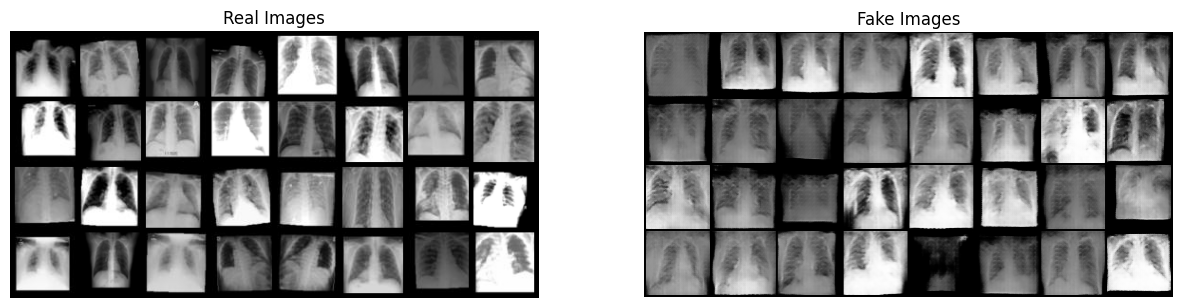

In [22]:
visualize_generated_imgs(generator, discriminator, num_epochs, metrics, selected_loader)

# **Generator and Discriminator Summary**

In [23]:
from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

In [24]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [25]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.25, inplace=False)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14